# Car Trim and Price Prediction
### By Roger Qiu

Objective: Given a training dataset of vehicles sold at different dealerships, accurately predict a vehicles trim and price given numerous features in a test set.

### import libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import random
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import *
from sklearn.naive_bayes import *
from sklearn.decomposition import *
from sklearn.tree import *
from sklearn.svm import *
from sklearn.neighbors import *

# show all columns
pd.set_option('display.max_columns', None)

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# download stopwords from NLTK
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# set random to 42 to repeat results
random.seed(42)
np.random.seed(42)

### EDA

In [80]:
train_data = pd.read_csv('Training_DataSet.csv')
train_data.head()

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,VehColorExt,VehColorInt,VehDriveTrain,VehEngine,VehFeats,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
0,3287,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091.0,SUV,False,White,Black,4X4,3.6L V6,"['Adaptive Cruise Control', 'Antilock Brakes',...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",8.600069,Jeep,39319.0,Grand Cherokee,Fair Price,NaN,Used,Automatic 8-Speed,2015,High Altitude,30990.0
1,3920,Fargo,False,Cadillac Certified Program,Gateway Chevrolet Cadillac,4.8,1456,ND,58103.0,SUV,True,Black,NaN,NaN,NaN,NaN,Gasoline,"1 Owner, Buyback Protection Eligible",2.920127,Cadillac,30352.0,XT5,Good Deal,Come take a look at our great pre-owned invent...,Used,NaN,2017,NaN,34860.0
2,4777,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,Brilliant Black Crystal Pearlcoat,Black,4x4/4WD,Regular Unleaded V-6 3.6 L/220,['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...,Gasoline,"1 Owner, Buyback Protection Eligible",28.107014,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,Laredo,23249.0
3,6242,Wentzville,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,False,Diamond Black Crystal Pearlcoat,Black,4WD,3.6L V6,"['Android Auto', 'Antilock Brakes', 'Apple Car...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",59.816875,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,Limited,31977.0
4,7108,Fayetteville,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,False,Radiant Silver Metallic,Cirrus,FWD,Gas V6 3.6L/222.6,"['4-Wheel Disc Brakes', 'ABS', 'Adjustable Ste...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",98.665301,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018,Luxury,33495.0


In [81]:
# 29 fields, 6298 records
print(train_data.shape)

(6298, 29)


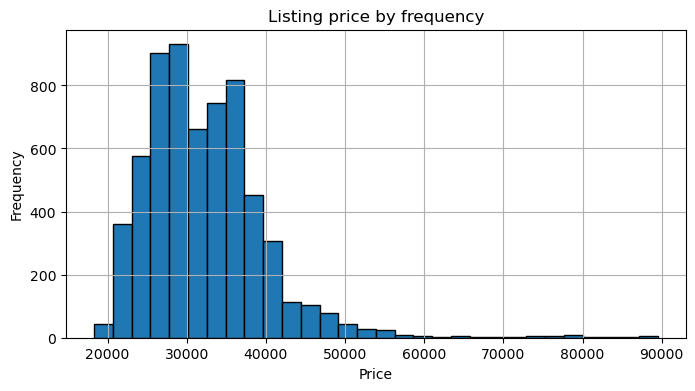

In [82]:
# histogram of Dealer_Listing_Price
plt.figure(figsize=(8, 4))
plt.hist(train_data['Dealer_Listing_Price'], bins=30, edgecolor='black')
plt.title('Listing price by frequency')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

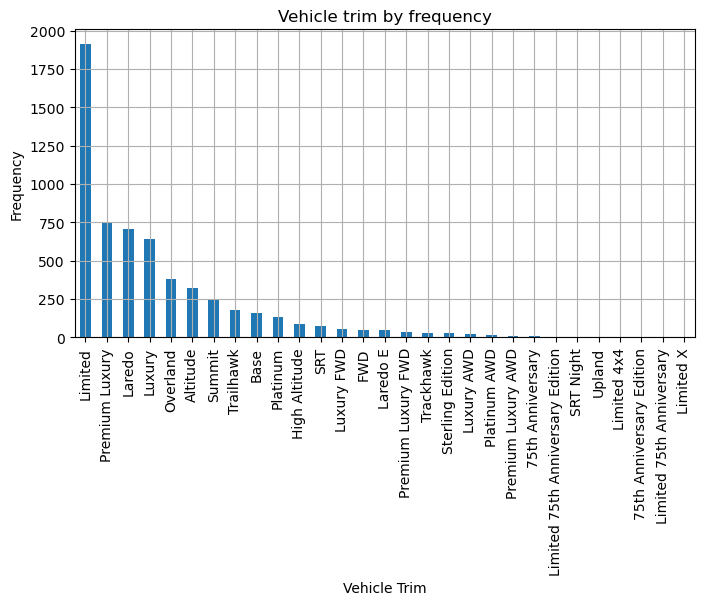

In [83]:
# bar chart of Vehicle_Trim
plt.figure(figsize=(8, 4))
train_data['Vehicle_Trim'].value_counts().plot(kind='bar')
plt.title('Vehicle trim by frequency')
plt.xlabel('Vehicle Trim')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [84]:
# check nulls

# count the null values in each field, print where more than 0 nulls
null_counts = train_data.isnull().sum()
print(null_counts[null_counts > 0])

SellerListSrc             2
SellerZip                 2
VehColorExt              73
VehColorInt             728
VehDriveTrain           401
VehEngine               361
VehFeats                275
VehFuel                   2
VehHistory              201
VehListdays               2
VehMileage                2
VehPriceLabel           285
VehSellerNotes          243
VehTransmission         197
Vehicle_Trim            405
Dealer_Listing_Price     52
dtype: int64


### pre-processing

In [85]:
# field columns with only one unique value
columns_to_remove = [col for col in train_data.columns if train_data[col].nunique() == 1]
columns_to_remove

['VehBodystyle', 'VehType']

In [86]:
# remove these 2 field from the dataset, they provide no additional info
train_data = train_data.drop(columns=columns_to_remove)
train_data.shape

(6298, 27)

In [87]:
# drop records with null Vehicle_Trim or Dealer_Listing_Price, these are our labels which we need values in
train_data = train_data.dropna(subset=['Vehicle_Trim', 'Dealer_Listing_Price'])

# count the null values in each field, print where more than 0 nulls
null_counts = train_data.isnull().sum()
print(null_counts[null_counts > 0])

SellerListSrc        2
SellerZip            2
VehColorExt         42
VehColorInt        426
VehDriveTrain       68
VehEngine           28
VehFeats            23
VehFuel              2
VehHistory         197
VehListdays          2
VehPriceLabel      233
VehSellerNotes      74
VehTransmission     32
dtype: int64


In [88]:
# instead of 6298 records, now its 5841
print(train_data.shape)

(5841, 27)


In [89]:
# create features by dropping id field and labels
X_train = train_data.drop(columns=['Vehicle_Trim', 'Dealer_Listing_Price', 'ListingID'])
print(X_train.shape)

(5841, 24)


In [90]:
# create the 2 labels fields
y_trim_train = train_data['Vehicle_Trim']
y_price_train = train_data['Dealer_Listing_Price']

print(y_trim_train.head())
print(y_price_train.head())

0    High Altitude
2           Laredo
3          Limited
4           Luxury
5          Limited
Name: Vehicle_Trim, dtype: object
0    30990.0
2    23249.0
3    31977.0
4    33495.0
5    27900.0
Name: Dealer_Listing_Price, dtype: float64


In [91]:
# check feature field types
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5841 entries, 0 to 6297
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SellerCity       5841 non-null   object 
 1   SellerIsPriv     5841 non-null   bool   
 2   SellerListSrc    5839 non-null   object 
 3   SellerName       5841 non-null   object 
 4   SellerRating     5841 non-null   float64
 5   SellerRevCnt     5841 non-null   int64  
 6   SellerState      5841 non-null   object 
 7   SellerZip        5839 non-null   float64
 8   VehCertified     5841 non-null   bool   
 9   VehColorExt      5799 non-null   object 
 10  VehColorInt      5415 non-null   object 
 11  VehDriveTrain    5773 non-null   object 
 12  VehEngine        5813 non-null   object 
 13  VehFeats         5818 non-null   object 
 14  VehFuel          5839 non-null   object 
 15  VehHistory       5644 non-null   object 
 16  VehListdays      5839 non-null   float64
 17  VehMake          58

In [92]:
# select all the groups of fields by type: numerical, categorical, boolean, text and list features
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns.difference(['VehSellerNotes','VehFeats'])
bool_cols = X_train.select_dtypes(include=['bool']).columns
text_col = 'VehSellerNotes'
list_col = 'VehFeats'

print(num_cols)
print(cat_cols)
print(bool_cols)
print(text_col)
print(list_col)

# still 24 fields
print(len(num_cols) + len(cat_cols) + len(bool_cols) + 1 + 1)

Index(['SellerRating', 'SellerRevCnt', 'SellerZip', 'VehListdays',
       'VehMileage', 'VehYear'],
      dtype='object')
Index(['SellerCity', 'SellerListSrc', 'SellerName', 'SellerState',
       'VehColorExt', 'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFuel',
       'VehHistory', 'VehMake', 'VehModel', 'VehPriceLabel',
       'VehTransmission'],
      dtype='object')
Index(['SellerIsPriv', 'VehCertified'], dtype='object')
VehSellerNotes
VehFeats
24


### pre-process numerical features

In [93]:
# for numerical features, impute missing values and scale them
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# fit on numerical fields for training data
X_train_num = num_imputer.fit_transform(X_train[num_cols])
X_train_num = scaler.fit_transform(X_train_num)

print(X_train_num[:5])
print(X_train_num.shape)

[[ 0.73661031 -0.32105247  0.14769339 -0.6983788   0.97497474 -1.45127235]
 [ 0.56213936  0.72258538  0.40213716 -0.41007283  0.94719888 -1.45127235]
 [ 0.21319747 -0.32941374  0.91147418  0.05858808 -0.47635222  1.01844168]
 [-0.39745085 -0.28912764  1.37681414  0.63275454 -0.52361722  1.01844168]
 [-1.00809917 -0.30661029 -1.51685333 -0.36779582  0.61665082  1.01844168]]
(5841, 6)


### pre-process categorical features

In [94]:
# impute missing values with 'missing' and one hot encode categorical features
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# fit on categorical training data
X_train_cat = cat_imputer.fit_transform(X_train[cat_cols])
X_train_cat = encoder.fit_transform(X_train_cat)

print(X_train_cat[:5])
print(X_train_cat.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(5841, 4004)


### pre-process boolean features

In [95]:
# preprocess boolean features, convert true or false 1 or 0
X_train_bool = X_train[bool_cols].astype(int).values

print(X_train_bool[:5])
print(X_train_bool.shape)

[[0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]]
(5841, 2)


### pre-process seller notes text

In [96]:
# check values
X_train[text_col].head()

0                                                  NaN
2    Backed by a rigorous 125-point inspection by f...
3    Drop by to see us and you will quickly see how...
4    Luxury, Exterior Parking Camera Rear, Front Du...
5    Priced below KBB Fair Purchase Price! Clean CA...
Name: VehSellerNotes, dtype: object

In [97]:
nltk.download('stopwords')

# remove stopwords and concatenate all text
stop_words = set(stopwords.words('english'))
print(list(stop_words)[:5])

["needn't", 'between', 'in', 'can', 'when']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/roger.qiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
# full nulls with empty strings
X_train[text_col] = X_train[text_col].fillna('')
X_train[text_col].head()

0                                                     
2    Backed by a rigorous 125-point inspection by f...
3    Drop by to see us and you will quickly see how...
4    Luxury, Exterior Parking Camera Rear, Front Du...
5    Priced below KBB Fair Purchase Price! Clean CA...
Name: VehSellerNotes, dtype: object

In [99]:
# combine all text data in a single string
text_data = ' '.join(X_train[text_col])
text_data[:50]

' Backed by a rigorous 125-point inspection by fact'

In [100]:
# remove stopwords
filtered_words = [word for word in text_data.split() if word.lower() not in stop_words]
filtered_words[:5]

['Backed', 'rigorous', '125-point', 'inspection', 'factory-trained']

In [101]:
# combine again into a single string
filtered_text = ' '.join(filtered_words)
filtered_text[:50]

'Backed rigorous 125-point inspection factory-train'

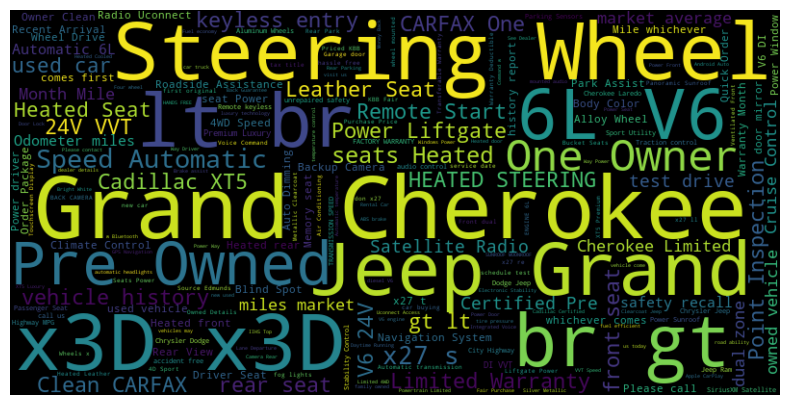

In [102]:
# create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(filtered_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [103]:
# create tfidf to convert text values into vectors
# remove stopwords that dont provide info and use 100 of the top ranked terms across the corpus
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

# fit the vectorizer to the text column
X_train_text = vectorizer.fit_transform(X_train[text_col].fillna('')).toarray()

print(X_train_text[2])
print(X_train_text.shape)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74619032 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.66573269 0.         0.        ]
(5841, 100

### pre-process vehicle features list

In [104]:
# check values
X_train[list_col].head()

0    ['Adaptive Cruise Control', 'Antilock Brakes',...
2    ['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...
3    ['Android Auto', 'Antilock Brakes', 'Apple Car...
4    ['4-Wheel Disc Brakes', 'ABS', 'Adjustable Ste...
5    ['1st and 2nd row curtain head airbags', '4-wh...
Name: VehFeats, dtype: object

In [105]:
# fill nulls, convert list to text
X_train[list_col] = X_train[list_col].fillna('[]').apply(eval).apply(lambda x: ','.join(x))
X_train[list_col].head()

0    Adaptive Cruise Control,Antilock Brakes,Audio ...
2    18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capabl...
3    Android Auto,Antilock Brakes,Apple CarPlay,Aud...
4    4-Wheel Disc Brakes,ABS,Adjustable Steering Wh...
5    1st and 2nd row curtain head airbags,4-wheel A...
Name: VehFeats, dtype: object

In [106]:
# use one hot encoder to convert comma seperated strings into a matrix with 1 or 0 for if the feature is present
feats_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_feats = feats_encoder.fit_transform(X_train[list_col].values.reshape(-1, 1))

print(X_train_feats[:5])
print(X_train_feats.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(5841, 797)


### combine features then use PCA to reduce dimentionality

In [107]:
# combine all preprocessed features together using hstack to horizontally concat the arrays
X_train_preprocessed = np.hstack((X_train_num, X_train_cat, X_train_bool, X_train_text, X_train_feats))

print(X_train_preprocessed[:1])
print(X_train_preprocessed.shape)

[[ 0.73661031 -0.32105247  0.14769339 ...  0.          0.
   0.        ]]
(5841, 4909)


In [108]:
# almost 5000 fields, so use principal component analysis to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_preprocessed)

# only 788 fields now
print(X_train_preprocessed.shape[1])
print(X_train_pca.shape[1])

4909
788


In [109]:
# check how the records look now
print(X_train_preprocessed[0][:5])
print(X_train_pca[0][:5])

[ 0.73661031 -0.32105247  0.14769339 -0.6983788   0.97497474]
[-1.37042827  0.24928243 -0.69933417  0.31303048 -0.11801419]


### preprocess trim label

In [110]:
print(y_trim_train.head())
print(y_price_train.head())

0    High Altitude
2           Laredo
3          Limited
4           Luxury
5          Limited
Name: Vehicle_Trim, dtype: object
0    30990.0
2    23249.0
3    31977.0
4    33495.0
5    27900.0
Name: Dealer_Listing_Price, dtype: float64


In [111]:
# encode categorical target variable y_trim_train
label_encoder = LabelEncoder()
y_trim_train_encoded = label_encoder.fit_transform(y_trim_train)

print(y_trim_train_encoded[:5])
print(y_trim_train_encoded.shape)

[ 5  6  8 13  8]
(5841,)


In [112]:
# create a mapping from the original labels to the encoded numbers
trim_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for trim, number in trim_mapping.items():
    print(f"{trim}: {number}")

75th Anniversary: 0
75th Anniversary Edition: 1
Altitude: 2
Base: 3
FWD: 4
High Altitude: 5
Laredo: 6
Laredo E: 7
Limited: 8
Limited 4x4: 9
Limited 75th Anniversary: 10
Limited 75th Anniversary Edition: 11
Limited X: 12
Luxury: 13
Luxury AWD: 14
Luxury FWD: 15
Overland: 16
Platinum: 17
Platinum AWD: 18
Premium Luxury: 19
Premium Luxury AWD: 20
Premium Luxury FWD: 21
SRT: 22
SRT Night: 23
Sterling Edition: 24
Summit: 25
Trackhawk: 26
Trailhawk: 27
Upland: 28


### split training data for validation set

In [113]:
# split features, trim label and price label into 70/30 for train and validation sets
X_train_final, X_val, y_trim_train_final, y_trim_val, y_price_train_final, y_price_val = train_test_split(
    X_train_pca, y_trim_train_encoded, y_price_train, test_size=0.3, random_state=42)

print(X_train_final.shape)
print(X_val.shape)

print(y_trim_train_final.shape)
print(y_trim_val.shape)

print(y_price_train_final.shape)
print(y_price_val.shape)

(4088, 788)
(1753, 788)
(4088,)
(1753,)
(4088,)
(1753,)


In [114]:
X_val[0][:5]

array([ 1.8161653 , -0.17188878, -1.66012565, -0.48802285,  0.29540282])

In [115]:
y_trim_val[0]

13

In [116]:
y_price_val[:1]

6147    35500.0
Name: Dealer_Listing_Price, dtype: float64

### evaluate classification models on trim labels

In [98]:
# train and logistic regression model
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train_final, y_trim_train_final)

# create trim predictions given validation set
y_trim_val_pred = logistic_reg.predict(X_val)

# check predictions vs actuals
print(y_trim_val_pred[:5])
print(y_trim_val[:5])

[13  2  8 25  8]
[13  2  2 25  8]


In [99]:
# check accuracy and f1 of the predictions compared to actuals
print(accuracy_score(y_trim_val, y_trim_val_pred))
print(f1_score(y_trim_val, y_trim_val_pred, average='weighted'))

0.8539646320593268
0.8459025699506811


In [100]:
# now train and test on random forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_final, y_trim_train_final)

y_trim_val_pred = random_forest.predict(X_val)

print(accuracy_score(y_trim_val, y_trim_val_pred))
print(f1_score(y_trim_val, y_trim_val_pred, average='weighted'))

0.6948088990302339
0.6440930059841969


In [101]:
# now train and test on k nearest neighbor
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_final, y_trim_train_final)

y_trim_val_pred = knn_clf.predict(X_val)

print(accuracy_score(y_trim_val, y_trim_val_pred))
print(f1_score(y_trim_val, y_trim_val_pred, average='weighted'))

0.6936679977181974
0.6737595332560347


In [102]:
# now train and test on naive bayes
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_final, y_trim_train_final)

y_trim_val_pred = naive_bayes.predict(X_val)

print(accuracy_score(y_trim_val, y_trim_val_pred))
print(f1_score(y_trim_val, y_trim_val_pred, average='weighted'))

0.4015972618368511
0.4207431829020433


### hyperparameter tuning to get best model with best parameters

In [103]:
# define the parameter grid for log reg
# C changes regularization amount while solver chooses different optimization type
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# create the log reg model again
logistic_reg = LogisticRegression(max_iter=1000)

# perform grid search with cross-validation
grid_search_lr = GridSearchCV(logistic_reg, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_final, y_trim_train_final)

# get the best parameters and the best model
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

print(best_params_lr)
print(best_model_lr)

{'C': 10, 'solver': 'liblinear'}
LogisticRegression(C=10, max_iter=1000, solver='liblinear')


In [106]:
# create predictions from validation features
y_trim_val_pred_lr = best_model_lr.predict(X_val)
print(y_trim_val_pred_lr[:5])

[13  2  2 25  8]


In [107]:
print(accuracy_score(y_trim_val, y_trim_val_pred_lr))
print(f1_score(y_trim_val, y_trim_val_pred_lr, average='weighted'))

0.8585282373074729
0.8544483011681455


In [109]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}

# Initialize the Random Forest model
random_forest = RandomForestClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_final, y_trim_train_final)

# Get the best parameters and the best model
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

print(best_params_rf)
print(best_model_rf)

{'max_depth': 20, 'n_estimators': 100}
RandomForestClassifier(max_depth=20, random_state=42)


In [110]:
# Predict on the validation set
y_trim_val_pred_rf = best_model_rf.predict(X_val)

# Calculate metrics
print(accuracy_score(y_trim_val, y_trim_val_pred_rf))
print(f1_score(y_trim_val, y_trim_val_pred_rf, average='weighted'))

0.679406731317741
0.6259801300356478


In [111]:
# best classification model is LogisticRegression(C=10, max_iter=1000, solver='liblinear')
# with accuracy and f1 of 86%

### evaluate regression models on price labels

In [112]:
# train Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train_final, y_price_train_final)

# predict prices
y_price_val_pred = linear_reg.predict(X_val)

print(y_price_val_pred[:5])
print(y_price_val[:5])

[32079.35250155 33094.18363729 30619.49401673 37255.49237462
 29743.81160114]
6147    35500.0
184     28637.0
174     28695.0
6021    38880.0
2533    29790.0
Name: Dealer_Listing_Price, dtype: float64


In [113]:
print(mean_squared_error(y_price_val, y_price_val_pred, squared=False))
print(r2_score(y_price_val, y_price_val_pred))

3007.7656746136336
0.8548957604797974


In [114]:
# Train Decision Tree Regressor
decision_tree_reg = DecisionTreeRegressor(random_state=42)
decision_tree_reg.fit(X_train_final, y_price_train_final)

# Predict and evaluate
y_price_val_pred = decision_tree_reg.predict(X_val)

print(mean_squared_error(y_price_val, y_price_val_pred, squared=False))
print(r2_score(y_price_val, y_price_val_pred))

6096.547938474299
0.40384376542526457


In [115]:
# Train Random Forest Regressor
random_forest_reg = RandomForestRegressor(random_state=42)
random_forest_reg.fit(X_train_final, y_price_train_final)

# Predict and evaluate
y_price_val_pred = random_forest_reg.predict(X_val)

print(mean_squared_error(y_price_val, y_price_val_pred, squared=False))
print(r2_score(y_price_val, y_price_val_pred))

4423.212391470294
0.6861893408328988


In [116]:
# Train Support Vector Regressor
svr = SVR()
svr.fit(X_train_final, y_price_train_final)

# Predict and evaluate
y_price_val_pred = svr.predict(X_val)

print(mean_squared_error(y_price_val, y_price_val_pred, squared=False))
print(r2_score(y_price_val, y_price_val_pred))

7926.585226717974
-0.007776834190083237


In [117]:
# Train K-Nearest Neighbors Regressor
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_final, y_price_train_final)

# Predict and evaluate
y_price_val_pred = knn_reg.predict(X_val)

print(mean_squared_error(y_price_val, y_price_val_pred, squared=False))
print(r2_score(y_price_val, y_price_val_pred))

4478.120847999408
0.6783498762953561


### hyperparameter tuning on the best linear regression model

In [122]:
# parameter grid for best ridge regression
# alpha controls regularization, solver is the optimizer
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 50],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

# initialize model
ridge_reg = Ridge()

# perform grid search, scoring rmse
grid_search_ridge = GridSearchCV(ridge_reg, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_final, y_price_train_final)

# get best parameter and model
best_params_ridge = grid_search_ridge.best_params_
best_model_ridge = grid_search_ridge.best_estimator_

# predict on validation set
y_price_val_pred_ridge = best_model_ridge.predict(X_val)

y_price_val_pred_ridge[:5]

array([32433.81369174, 32258.65822153, 30668.6735075 , 37517.93789474,
       29725.2143707 ])

In [127]:
best_model_ridge

Ridge(alpha=1, solver='saga')

In [123]:
print(mean_squared_error(y_price_val, y_price_val_pred_ridge, squared=False))
print(r2_score(y_price_val, y_price_val_pred_ridge))

2917.171100317708
0.8635052621153299


In [125]:
# parameter grid for lasso regression
# alpha controls regularization, max iter is iterations
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 50],
    'max_iter': [1000, 2000, 3000]
}

# initialize model
lasso_reg = Lasso()

# perform grid search
grid_search_lasso = GridSearchCV(lasso_reg, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_final, y_price_train_final)

# get best param and model
best_params_lasso = grid_search_lasso.best_params_
best_model_lasso = grid_search_lasso.best_estimator_

# predict on validation set
y_price_val_pred_lasso = best_model_lasso.predict(X_val)

print(y_price_val_pred_lasso[:5])
print(y_price_val[:5])

[32944.60322573 32262.39268183 30667.2036255  37623.06597038
 29721.26259184]
6147    35500.0
184     28637.0
174     28695.0
6021    38880.0
2533    29790.0
Name: Dealer_Listing_Price, dtype: float64


In [126]:
# get rmse and r2
print(mean_squared_error(y_price_val, y_price_val_pred_lasso, squared=False))
print(r2_score(y_price_val, y_price_val_pred_lasso))

2955.8838259114113
0.8598584791657555


In [129]:
# best regression model for price
best_model_ridge

Ridge(alpha=1, solver='saga')

In [130]:
# best classification model for trim
best_model_lr

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

- Best model to predict trim: LogisticRegression(C=10, max_iter=1000, solver='liblinear') with accuracy and f1 of 86%
- Best model to predict price: Ridge(alpha=1, solver='saga') with RMSE of 2917 and R2 of 86%

### use best models to predict price and trim on test set

In [222]:
test_data = pd.read_csv('Test_DataSet.csv')
test_data.head()

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,VehColorExt,VehColorInt,VehDriveTrain,VehEngine,VehFeats,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear
0,8622015,Seneca,False,HomeNet Automotive,Lake Keowee Chrysler Dodge Jeep Ram,2.5,59,SC,29678,SUV,False,Stellar Black Metallic,Cirrus,FWD,Gas V6 3.6L/222.6,"['4-Wheel Disc Brakes', 'ABS', 'Active Suspens...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",143.991262,Cadillac,13625.0,XT5,Good Deal,Thank you for visiting another one of Lake Keo...,Used,8-Speed Automatic,2018
1,8625693,Bedford,False,Inventory Command Center,North Coast Auto Mall,4.7,2116,OH,44146,SUV,False,True Blue Pearlcoat,Black,Four Wheel Drive,3.6L V6 CYLINDER,"['12v Power Outlet', 'ABS Brakes', 'Air Condit...",Gasoline,"1 Owner, Accident(s) Reported, Non-Personal Us...",138.770486,Jeep,42553.0,Grand Cherokee,Good Deal,This 2017 Jeep Grand Cherokee 4dr Limited 4x4 ...,Used,8-Speed Automatic,2017
2,8625750,Webster,False,Jeep Certified Program,Marina Chrysler Dodge Jeep Mitsubishi RAM,3.9,46,NY,14580,SUV,True,Brilliant Black Crystal Pearlcoat,Black,4WD,3.6L V6 24V MPFI DOHC Flexible Fuel,"['1st and 2nd row curtain head airbags', '4-wh...",E85 Flex Fuel,"1 Owner, Buyback Protection Eligible",31.951088,Jeep,48951.0,Grand Cherokee,Good Deal,Certified. Brilliant Black Crystal Pearlcoat 2...,Used,8-Speed Automatic,2015
3,8626885,Louisville,False,Digital Motorworks (DMi),Oxmoor Ford Lincoln,4.5,1075,KY,40222,SUV,False,Brilliant Black Crystal Pearlcoat,Black,4WD,3.6L V6 24V MPFI DOHC,"['1st and 2nd row curtain head airbags', '4-wh...",Gasoline,"1 Owner, Buyback Protection Eligible",5.950127,Jeep,44179.0,Grand Cherokee,Good Deal,2015 Jeep Grand Cherokee ***THIS VEHICLE IS AT...,Used,8-Speed Automatic,2015
4,8627430,Palmyra,False,Digital Motorworks (DMi),F.C. Kerbeck &amp; Sons,4.6,162,NJ,8065,SUV,False,Harbor Blue Metallic,Jet Black,AWD,3.6L V6 24V GDI DOHC,"['1st and 2nd row curtain head airbags', '4-wh...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",24.672986,Cadillac,22269.0,XT5,Good Deal,"AWD, CarFax One Owner! Navigation, Back-up Cam...",Used,8-Speed Automatic,2018


In [223]:
# field columns with only one unique value
columns_to_remove = [col for col in test_data.columns if test_data[col].nunique() == 1]
columns_to_remove

['VehBodystyle', 'VehType']

In [224]:
# remove these 2 field from the dataset, they provide no additional info
test_data = test_data.drop(columns=columns_to_remove)
test_data.shape

(1000, 25)

In [225]:
# create features by dropping id field
X_test = test_data.drop(columns=['ListingID'])
print(X_test.shape)

(1000, 24)


In [226]:
# check feature field types
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SellerCity       1000 non-null   object 
 1   SellerIsPriv     1000 non-null   bool   
 2   SellerListSrc    1000 non-null   object 
 3   SellerName       1000 non-null   object 
 4   SellerRating     1000 non-null   float64
 5   SellerRevCnt     1000 non-null   int64  
 6   SellerState      1000 non-null   object 
 7   SellerZip        1000 non-null   int64  
 8   VehCertified     1000 non-null   bool   
 9   VehColorExt      993 non-null    object 
 10  VehColorInt      892 non-null    object 
 11  VehDriveTrain    936 non-null    object 
 12  VehEngine        942 non-null    object 
 13  VehFeats         963 non-null    object 
 14  VehFuel          1000 non-null   object 
 15  VehHistory       973 non-null    object 
 16  VehListdays      1000 non-null   float64
 17  VehMake        

In [227]:
# select all the groups of fields by type: numerical, categorical, boolean, text and list features
num_cols = X_test.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_test.select_dtypes(include=['object']).columns.difference(['VehSellerNotes','VehFeats'])
bool_cols = X_test.select_dtypes(include=['bool']).columns
text_col = 'VehSellerNotes'
list_col = 'VehFeats'

print(num_cols)
print(cat_cols)
print(bool_cols)
print(text_col)
print(list_col)

# still 24 fields
print(len(num_cols) + len(cat_cols) + len(bool_cols) + 1 + 1)

Index(['SellerRating', 'SellerRevCnt', 'SellerZip', 'VehListdays',
       'VehMileage', 'VehYear'],
      dtype='object')
Index(['SellerCity', 'SellerListSrc', 'SellerName', 'SellerState',
       'VehColorExt', 'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFuel',
       'VehHistory', 'VehMake', 'VehModel', 'VehPriceLabel',
       'VehTransmission'],
      dtype='object')
Index(['SellerIsPriv', 'VehCertified'], dtype='object')
VehSellerNotes
VehFeats
24


### pre-process numerical features

In [228]:
# for numerical features, impute missing values and scale them
# fit on numerical fields for training data
X_test_num = num_imputer.transform(X_test[num_cols])
X_test_num = scaler.transform(X_test_num)

print(X_test_num[:5])
print(X_test_num.shape)

[[-1.44427654 -0.30052937 -0.77184994  1.30265674 -0.99649737  1.01844168]
 [ 0.47490389  1.26302713 -0.04931951  1.22549546  1.22311597  0.19520367]
 [-0.22297991 -0.31041086 -1.52584252 -0.35325873  1.71402742 -1.45127235]
 [ 0.30043294  0.47174744 -0.24528367 -0.73754404  1.34787715 -1.45127235]
 [ 0.38766841 -0.22223752 -1.85120095 -0.46082658 -0.33325284  1.01844168]]
(1000, 6)


### pre-process categorical features

In [229]:
# impute missing values with 'missing' and one hot encode categorical features
# fit on categorical training data
X_test_cat = cat_imputer.transform(X_test[cat_cols])
X_test_cat = encoder.transform(X_test_cat)

print(X_test_cat[:5])
print(X_test_cat.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 4004)


### pre-process boolean features

In [230]:
# preprocess boolean features, convert true or false 1 or 0
X_test_bool = X_test[bool_cols].astype(int).values

print(X_test_bool[:5])
print(X_test_bool.shape)

[[0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]]
(1000, 2)


### pre-process seller notes text

In [231]:
# check values
X_test[text_col].head()

0    Thank you for visiting another one of Lake Keo...
1    This 2017 Jeep Grand Cherokee 4dr Limited 4x4 ...
2    Certified. Brilliant Black Crystal Pearlcoat 2...
3    2015 Jeep Grand Cherokee ***THIS VEHICLE IS AT...
4    AWD, CarFax One Owner! Navigation, Back-up Cam...
Name: VehSellerNotes, dtype: object

In [232]:
# create tfidf to convert text values into vectors
# remove stopwords that dont provide info and use 100 of the top ranked terms across the corpus
# fit the vectorizer to the text column
X_test_text = vectorizer.transform(X_test[text_col].fillna('')).toarray()

print(X_test_text[2])
print(X_test_text.shape)

[0.2438432  0.2444744  0.09450755 0.         0.08205055 0.06905422
 0.06154613 0.15340564 0.         0.08194329 0.         0.05672536
 0.         0.07859434 0.         0.         0.         0.
 0.17426451 0.         0.         0.25816392 0.0621827  0.09179497
 0.         0.         0.         0.17352975 0.06491281 0.08563113
 0.         0.07734391 0.         0.         0.         0.
 0.07625276 0.07695312 0.         0.08781169 0.0649596  0.06216842
 0.         0.         0.1483974  0.08275679 0.16667804 0.07795112
 0.08146509 0.05885015 0.07757607 0.         0.         0.13559938
 0.         0.07432454 0.         0.23672637 0.         0.
 0.         0.06709033 0.06474184 0.05772639 0.         0.
 0.08096808 0.10976387 0.0687887  0.         0.06629873 0.08232031
 0.07517658 0.         0.28666402 0.         0.06861293 0.
 0.         0.         0.         0.06749372 0.         0.06299329
 0.         0.12970106 0.         0.         0.08497588 0.
 0.11662966 0.35989446 0.         0.0711108

### pre-process vehicle features list

In [233]:
# check values
X_test[list_col].head()

0    ['4-Wheel Disc Brakes', 'ABS', 'Active Suspens...
1    ['12v Power Outlet', 'ABS Brakes', 'Air Condit...
2    ['1st and 2nd row curtain head airbags', '4-wh...
3    ['1st and 2nd row curtain head airbags', '4-wh...
4    ['1st and 2nd row curtain head airbags', '4-wh...
Name: VehFeats, dtype: object

In [234]:
# fill nulls, convert list to text
X_test[list_col] = X_test[list_col].fillna('[]').apply(eval).apply(lambda x: ','.join(x))
X_test[list_col].head()

0    4-Wheel Disc Brakes,ABS,Active Suspension,Adju...
1    12v Power Outlet,ABS Brakes,Air Conditioning,A...
2    1st and 2nd row curtain head airbags,4-wheel A...
3    1st and 2nd row curtain head airbags,4-wheel A...
4    1st and 2nd row curtain head airbags,4-wheel A...
Name: VehFeats, dtype: object

In [235]:
# use one hot encoder to convert comma seperated strings into a matrix with 1 or 0 for if the feature is present
X_test_feats = feats_encoder.transform(X_test[list_col].values.reshape(-1, 1))

print(X_test_feats[:5])
print(X_test_feats.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 797)


### combine features then use PCA to reduce dimentionality

In [236]:
# combine all preprocessed features together using hstack to horizontally concat the arrays
X_test_preprocessed = np.hstack((X_test_num, X_test_cat, X_test_bool, X_test_text, X_test_feats))

print(X_test_preprocessed[:1])
print(X_test_preprocessed.shape)

[[-1.44427654 -0.30052937 -0.77184994 ...  0.          0.
   0.        ]]
(1000, 4909)


In [237]:
# use principal component analysis from earlier to retain 95% of variance
X_test_pca = pca.transform(X_test_preprocessed)

# only 788 fields now
print(X_test_preprocessed.shape[1])
print(X_test_pca.shape[1])

4909
788


In [238]:
# check how the records look now
print(X_test_preprocessed[0][:5])
print(X_test_pca[0][:5])

[-1.44427654 -0.30052937 -0.77184994  1.30265674 -0.99649737]
[ 2.02366936 -1.58549429  0.60574677  0.11481991  1.33805313]


In [239]:
# predict prices on test set
y_price_pred_ridge = best_model_ridge.predict(X_test_pca)
y_price_pred_ridge[:5]

array([44726.30988604, 23094.37984588, 21849.13222156, 24999.6774848 ,
       41616.42091966])

In [240]:
# predict trim on test set
y_trim_pred_lr = best_model_lr.predict(X_test_pca)
y_trim_pred_lr[:5]

array([19,  8,  6,  8, 19])

In [242]:
# conver trim from numerical back into categorical text
y_trim_pred_text = label_encoder.inverse_transform(y_trim_pred_lr)
y_trim_pred_text[:5]

array(['Premium Luxury', 'Limited', 'Laredo', 'Limited', 'Premium Luxury'],
      dtype=object)

In [243]:
test_data = pd.read_csv('Test_DataSet.csv')

# add the predictions back to the test_data
test_data['Vehicle_Trim'] = y_trim_pred_text
test_data['Dealer_Listing_Price'] = y_price_pred_ridge

test_data.head()

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,VehColorExt,VehColorInt,VehDriveTrain,VehEngine,VehFeats,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
0,8622015,Seneca,False,HomeNet Automotive,Lake Keowee Chrysler Dodge Jeep Ram,2.5,59,SC,29678,SUV,False,Stellar Black Metallic,Cirrus,FWD,Gas V6 3.6L/222.6,"['4-Wheel Disc Brakes', 'ABS', 'Active Suspens...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",143.991262,Cadillac,13625.0,XT5,Good Deal,Thank you for visiting another one of Lake Keo...,Used,8-Speed Automatic,2018,Premium Luxury,44726.309886
1,8625693,Bedford,False,Inventory Command Center,North Coast Auto Mall,4.7,2116,OH,44146,SUV,False,True Blue Pearlcoat,Black,Four Wheel Drive,3.6L V6 CYLINDER,"['12v Power Outlet', 'ABS Brakes', 'Air Condit...",Gasoline,"1 Owner, Accident(s) Reported, Non-Personal Us...",138.770486,Jeep,42553.0,Grand Cherokee,Good Deal,This 2017 Jeep Grand Cherokee 4dr Limited 4x4 ...,Used,8-Speed Automatic,2017,Limited,23094.379846
2,8625750,Webster,False,Jeep Certified Program,Marina Chrysler Dodge Jeep Mitsubishi RAM,3.9,46,NY,14580,SUV,True,Brilliant Black Crystal Pearlcoat,Black,4WD,3.6L V6 24V MPFI DOHC Flexible Fuel,"['1st and 2nd row curtain head airbags', '4-wh...",E85 Flex Fuel,"1 Owner, Buyback Protection Eligible",31.951088,Jeep,48951.0,Grand Cherokee,Good Deal,Certified. Brilliant Black Crystal Pearlcoat 2...,Used,8-Speed Automatic,2015,Laredo,21849.132222
3,8626885,Louisville,False,Digital Motorworks (DMi),Oxmoor Ford Lincoln,4.5,1075,KY,40222,SUV,False,Brilliant Black Crystal Pearlcoat,Black,4WD,3.6L V6 24V MPFI DOHC,"['1st and 2nd row curtain head airbags', '4-wh...",Gasoline,"1 Owner, Buyback Protection Eligible",5.950127,Jeep,44179.0,Grand Cherokee,Good Deal,2015 Jeep Grand Cherokee ***THIS VEHICLE IS AT...,Used,8-Speed Automatic,2015,Limited,24999.677485
4,8627430,Palmyra,False,Digital Motorworks (DMi),F.C. Kerbeck &amp; Sons,4.6,162,NJ,8065,SUV,False,Harbor Blue Metallic,Jet Black,AWD,3.6L V6 24V GDI DOHC,"['1st and 2nd row curtain head airbags', '4-wh...",Gasoline,"1 Owner, Non-Personal Use Reported, Buyback Pr...",24.672986,Cadillac,22269.0,XT5,Good Deal,"AWD, CarFax One Owner! Navigation, Back-up Cam...",Used,8-Speed Automatic,2018,Premium Luxury,41616.420920


In [245]:
# select 3 required fields and write out
output_data = test_data[['ListingID', 'Vehicle_Trim', 'Dealer_Listing_Price']]
output_data.to_csv('test_data_with_predictions.csv', index=False)

### prediction visualizations

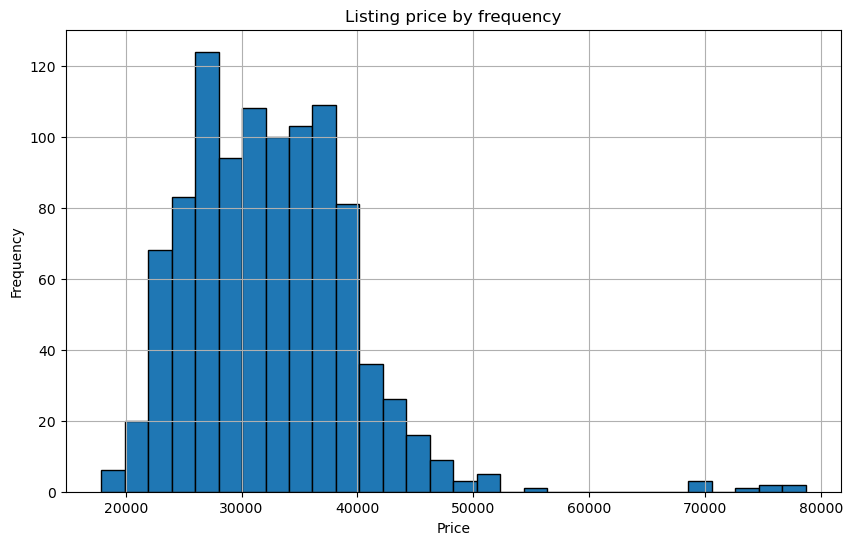

In [249]:
# gistogram of Dealer_Listing_Price
plt.figure(figsize=(10, 6))
plt.hist(output_data['Dealer_Listing_Price'], bins=30, edgecolor='black')
plt.title('Listing price by frequency')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

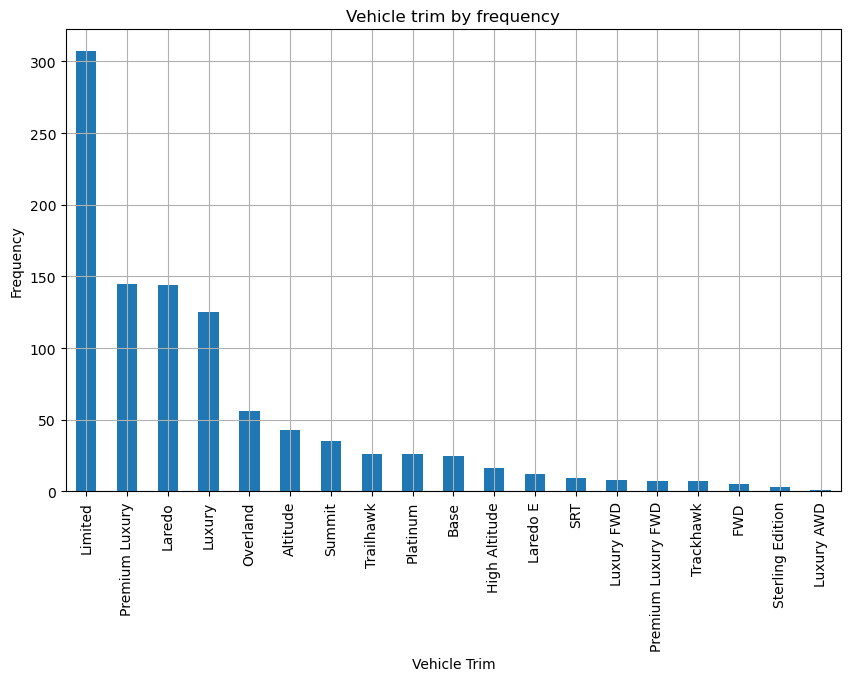

In [248]:
# bar Chart of Vehicle_Trim
plt.figure(figsize=(10, 6))
output_data['Vehicle_Trim'].value_counts().plot(kind='bar')
plt.title('Vehicle trim by frequency')
plt.xlabel('Vehicle Trim')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Conclusion:
Based on our 2 models, we were able to correctly predict trims on validation data by an accuracy and F1 of 85%. The accuracy means that of 100 predictions for vehicle trims, 85 were correct.The F1 means the balance between correctly predicted trims and identifying all relevant trims is good.

On the price predictions, we were able to predict prices with an RMSE of 2917 and an R² score of 86%. The RMSE tells us that on average, the price predictions are off by $2917 and the R^2 tells us the model explains 86% of the variation in vehicle prices.